In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import cycle

from datetime import datetime, date

from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### To start first go to 'Functions' section and run that cell.

## Goal and ideas

The goal is to create model which given home team, vistor and date will predict which team will win. We're focusing less on maximazing the accuracy but more on maximazing the amount of money made on betting on games using predictions provided by our model.

The idea is to use Elo ratings for each team to create it's skill function varying in time which is intuitive. To predict which team is going to win we simply need to compare those functions and team with greater value of the skill function will probably defeat the other.

We'll use Gaussian Process Regression which uses kernels and tunes its hyperparameters to provide the best fit. Because we have a lot of data, fitting a regression for each team using all Elo ratings would be time consuming. To make it quick we'll use only Elo ratings after the first game in each month (it still gives us good amount of information and gives us reasonable skill function).

The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess. It updates after each game depending on the result (if a very good team beats a very bad team it's Elo score rises insignificantly, but if it loses the value of Elo rating goes down hard).

## Load the data

It contains information about NBA games starting from 1946-1947 season.

In [3]:
!curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o data/nba_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9256k  100 9256k    0     0  4261k      0  0:00:02  0:00:02 --:--:-- 4261k


In [4]:
df = pd.read_csv('data/nba_data.csv')

We'll use only date, season, teams, scores, and post game Elo ratings.

In [5]:
df = df[['date', 'season', 'team1', 'team2', 'score1', 'score2', 'elo1_post', 'elo2_post']]
df.head()

,date,season,team1,team2,score1,score2,elo1_post,elo2_post
0,1946-11-01,1947,TRH,NYK,66.0,68.0,1293.2767,1306.7233
1,1946-11-02,1947,CHS,NYK,63.0,47.0,1309.6521,1297.0712
2,1946-11-02,1947,PRO,BOS,59.0,53.0,1305.1542,1294.8458
3,1946-11-02,1947,STB,PIT,56.0,51.0,1304.6908,1295.3092
4,1946-11-02,1947,DTF,WSC,33.0,50.0,1279.6189,1320.3811


## Advantage of playing at home
We assume that playing it's more common for a home team to win. Let's check if that's correct and if so, how crutial it is. 

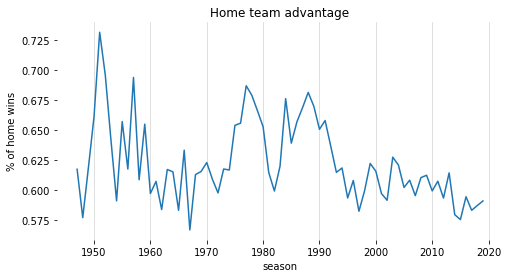

In [6]:
x, y = home_team_adv(df)
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Home team advantage')
ax.set_xlabel('season')
ax.set_ylabel('% of home wins')
for spine in ('top', 'bottom', 'right', 'left'):
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.plot(x, y)
None

In last 10 years home team is winning about 60% of games. We should create a constant telling us advantage given to the team by playing at home. Adding 35 Elo Rating points works the best when optimizing accuracy of the model and money made on betting.

In [7]:
home_team_adv = 35

## Create skill function for each team
Using ratings of each team at the beginning of the month we'll fit a Gaussian Process Regression using Matern kernel with some noise.

In [8]:
teams = np.unique(np.append(df['team1'], df['team2']))

In [9]:
l_scale = 5 * 365.25 * 24 * 60 * 60
noise = 0.1
kernel = Matern(nu=5/2, length_scale=l_scale, length_scale_bounds=(l_scale/10, l_scale*10)) + \
        WhiteKernel(noise_level=noise, noise_level_bounds=(noise, noise))

In [10]:
gprs = defaultdict(object)
for team in tqdm(teams):
    gpr = collect_data_and_fit_gpr(team)
    gprs[team] = gpr

100%|██████████| 102/102 [00:03<00:00, 27.30it/s]


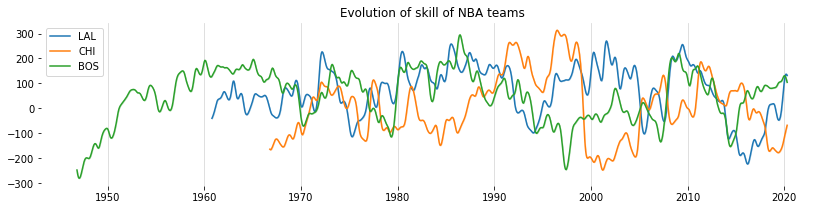

In [11]:
plot_skills(['LAL', 'CHI', 'BOS'], gprs)

## Check the accuracy of our predictor

Using our data contating information from 1946-1947 season let's check how well the model predict results.

In [12]:
confussion_matrix = compute_confussion_matrix(df)

100%|██████████| 69635/69635 [00:36<00:00, 1934.25it/s]


In [13]:
print(f'Confussion matrix:\n{confussion_matrix}\nAccuracy: \
{round(np.sum(np.diag(confussion_matrix)) / np.sum(confussion_matrix), 2)}%')

Confussion matrix:
[[31287. 11553.]
 [10213. 16582.]]
Accuracy: 0.69%


Accuracy seems to be quite good but from the testing notebook we know that selecting a team with higher Elo Rating as a winner provided 66% accuracy with similar looking confussion matrix.

## To know if the predictor provides us with useful data, check if we'll will make any money betting on every game \\$10.

In [14]:
games_df = pd.read_csv('data/nba_games_all.csv')
lines_df = pd.read_csv('data/nba_betting_money_line.csv')

games_df = games_df[games_df['is_home'] == 'f']
book = lines_df['book_name'].value_counts().index[0]
lines_df = lines_df[lines_df['book_name'] == book]

lg_df = games_df.merge(lines_df, on='game_id')
lg_df.head()

,game_id,game_date,matchup,team_id_x,is_home,wl,w,l,w_pct,min,...,a_team_id_x,season_year,season_type,season,book_name,book_id,team_id_y,a_team_id_y,price1,price2
0,20800741,2009-02-06,SAC vs. UTA,1610612762,f,W,29.0,22.0,0.569,240,...,1610612758,2008,Regular Season,2008-09,5Dimes,19,1610612762,1610612758,-142.0,132.0
1,20800701,2009-01-31,POR vs. UTA,1610612762,f,L,26.0,22.0,0.542,240,...,1610612757,2008,Regular Season,2008-09,5Dimes,19,1610612762,1610612757,400.0,-500.0
2,20800584,2009-01-16,MEM vs. UTA,1610612762,f,W,24.0,16.0,0.600,240,...,1610612763,2008,Regular Season,2008-09,5Dimes,19,1610612762,1610612763,-175.0,165.0
3,20800440,2008-12-27,HOU vs. UTA,1610612762,f,L,18.0,14.0,0.563,290,...,1610612745,2008,Regular Season,2008-09,5Dimes,19,1610612762,1610612745,410.0,-460.0
4,20800395,2008-12-20,CHI vs. UTA,1610612762,f,L,17.0,12.0,0.586,240,...,1610612741,2008,Regular Season,2008-09,5Dimes,19,1610612762,1610612741,-130.0,120.0


As tested there is an opitmal betting line providing the best made placed on bets : money won ratio. If line for the worse team is above 250 (for betting \\$100 we'll win \\$250) it's not worth to place bet. If our prediction is correct we'll win almost nothing but we risk losing that money if the better team loses.

In [15]:
max_opt_line = 250
money_d, money_s, n = check_money_made_on_betting(lg_df, max_opt_line)

100%|██████████| 14894/14894 [00:08<00:00, 1844.18it/s]


In [16]:
print_betting_info(money_d, money_s, n)

Total money made: $4413.03, first bet placed: 2006-11-01, last: 2018-05-28
Average money made from one bet: $0.59, bets taken: 7526, bets skipped: 7368
Average money made in one day: $2.01
Average money made in a season: $367.75
The worst season was 2017-18 with $83.06 made, the best season - 2007-08 with $627.0 made
The worst day was 2012-02-04 with $-71.39 made, the best day - 2007-01-10 with $68.83 made


From each \\$10 we were able to make about \\$0.6 which gives us 6%. Accuracy from basic comparing Elo Ratings may be similar to accuracy given by our model but it's completely useless - we would lost \\$1700 using that technique.

It means that the model was able to predict that a team with worse rating will win because it played well before and the decrease in rating was probably a bad luck.

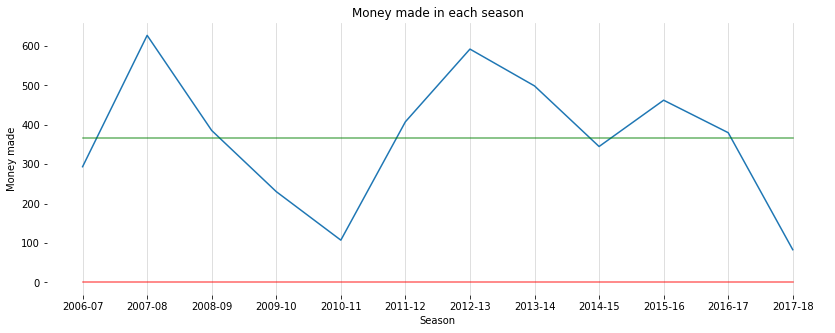

In [17]:
plot_money_made_season(money_s)

In [22]:
t = datetime.fromisoformat('2020-02-10').timestamp()

t = np.array(t).reshape(-1, 1)

for t1, t2 in (['OKC', 'BOS'], ['ATL', 'NYK'], ['HOU', 'UTA']):
    skill1 = gprs[t1].predict(t)
    skill2 = gprs[t2].predict(t)
    skill1 += home_team_adv
    print(f'{t1} - {skill1}\tvs.\t{t2} - {skill2}')

OKC - [115.14675791]	vs.	BOS - [127.14998885]
ATL - [-114.83173401]	vs.	NYK - [-161.64768629]
HOU - [138.95223645]	vs.	UTA - [107.26315461]


# Functions

In [2]:
def fit_gpr(train_x, train_y, kernel, return_gpr=False):
    '''
    fit Gaussian Process Regression using training data
    '''
    if isinstance(train_x, list):
        train_x = np.array(train_x).reshape(-1, 1)
    
    gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False)
    gpr.fit(train_x, train_y)
    
    return gpr


def plot_skills(items, gprs, figsize=(14.0, 3.0), title='Evolution of skill of NBA teams', xlims=None):
    '''
    plot skill of each team given in items list
    '''
    colors = cycle(plt.cm.tab10(np.linspace(0, 1, 10)))
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title(title)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.grid(axis='x', alpha=0.5)
    
    if xlims is not None:
        xmin = datetime.fromisoformat(xlims[0]).timestamp()
        xmax = datetime.fromisoformat(xlims[1]).timestamp()
    
    if isinstance(items, list):
        for team in items:
            color = next(colors)
            gpr = gprs[team]
            dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
            dates = [datetime.fromisoformat(el).timestamp() for el in dates]
            if xlims == None:
                x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
            else:
                x = np.linspace(max(min(dates), xmin), min(max(dates), xmax), 1000).reshape(-1, 1)
            y, std = gpr.predict(x, return_std=True)

            x = [datetime.fromtimestamp(t) for t in x]
            ax.plot(x, y, color=color, label=team)
            ax.fill_between(x, y-std, y+std, color=color, alpha=0.2)
        ax.legend()
    else:
        team = items
        gpr = gprs[team]
        dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
        dates = [datetime.fromisoformat(el).timestamp() for el in dates]
        if xlims == None:
            x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
        else:
            x = np.linspace(max(min(dates), xmin), min(max(dates), xmax), 1000).reshape(-1, 1)
        y = gpr.predict(x)
        
        x = [datetime.fromtimestamp(t) for t in x]
        ax.plot(x, y, label=team)
        ax.legend()
        
        
def predict_result(team1, team2, t):
    '''
    check who had greater skill at given time
    '''
    if isinstance(t, list):
        # make multiple predictions for those 2 teams
        if isinstance(t[0], str):
            for i in range(len(t)):
                t[i] = datetime.fromisoformat(t[i]).timestamp()
        
        t = np.array(t).reshape(-1, 1)
        
        skills1 = gprs[team1].predict(t)
        skills2 = gprs[team2].predict(t)
        skills1 += home_team_adv
        
        res = np.full(len(t), team1)
        res[skills1 < skills2] = team2
        return res
        
    else:
        if isinstance(t, str):
            t = datetime.fromisoformat(t).timestamp()

        t = np.array(t).reshape(-1, 1)
        skill1 = gprs[team1].predict(t)
        skill2 = gprs[team2].predict(t)
        skill1 += home_team_adv

        if skill1 > skill2:
            return team1
        else:
            return team2

        
def money_boost(line, our_bet):
    '''
    how much money we made from a bet
    '''
    if line < 0:
        return 100 * (our_bet / -line)
    else:
        return line / (100 / our_bet)


def collect_data_and_fit_gpr(team):
    '''
    for given team collect Elo ratings from start of each month and use it to fit Gaussian Process Regression
    '''
    dates = np.append(df[df['team1'] == team]['date'], df[df['team2'] == team]['date'])
    e = np.append(df[df['team1'] == team]['elo1_post'], df[df['team2'] == team]['elo2_post'])
    
    idx = dates < datetime.today().strftime('%Y-%m-%d')
    dates = dates[idx]
    e = e[idx]
    
    idx = np.argsort(dates)
    dates = dates[idx]
    e = e[idx]
    
    dates = np.array([datetime.fromisoformat(el).timestamp() for el in dates])
    e -= 1500

    months = np.array(list(map(lambda x: datetime.fromtimestamp(x).month, dates)))
    idx = np.nonzero(months[1:] != months[:-1])[0]
    
    train_x = dates[idx].reshape(-1, 1)
    train_y = e[idx]


    gpr = fit_gpr(train_x, train_y, kernel, return_gpr=True)
    
    return gpr


def home_team_adv(df):
    '''
    computes how many games did home team win in each season
    '''
    last_s = df.iloc[0]['season']
    gp = home_w = 0
    x, y = [], []
    
    for s in np.unique(df['season']):
        if s == 2020:
            break
        sub_df = df[df['season'] == s]
        won = np.count_nonzero(sub_df['score1'] > sub_df['score2'])
        x.append(s)
        y.append(won / len(sub_df))

    return x, y


def compute_confussion_matrix(df):
    '''
    check the accuracy of our model
    '''
    confussion_matrix = np.zeros((2, 2))

    for i in tqdm(range(len(df))):
        row = df.iloc[i]

        if row['score1'] > row['score2']:
            home_w = True
            result = row['team1']
        else:
            home_w = False
            result = row['team2']

        pred = predict_result(row['team1'], row['team2'], row['date'])

        if home_w:
            if result == pred:
                confussion_matrix[0][0] += 1
            else:
                confussion_matrix[0][1] += 1
        else:
            if result == pred:
                confussion_matrix[1][1] += 1
            else:
                confussion_matrix[1][0] += 1
    return confussion_matrix


def check_money_made_on_betting(lg_df, max_opt_line):
    '''
    returns 2 dicts: money made in season and money made daily
    '''
    money_s = defaultdict(int)
    money_d = defaultdict(int)
    our_bet = 10
    n = 0

    for i in tqdm(range(len(lg_df)), position=0, leave=True):
        row = lg_df.iloc[i]
        t = row['game_date']
        s = row['season']
        t1, t2 = row['matchup'].split(' vs. ')

        if t1 not in teams or t2 not in teams:
            continue

        if row['price1'] > max_opt_line or row['price2'] > max_opt_line:
            continue

        pred = predict_result(t1, t2, t)
        n += 1

        if pred == t2 and row['wl'] == 'W':
            money_d[t] += money_boost(row['price1'], our_bet)
            money_s[s] += money_boost(row['price1'], our_bet)
        elif pred == t1 and row['wl'] == 'L':
            money_d[t] += money_boost(row['price2'], our_bet)
            money_s[s] += money_boost(row['price2'], our_bet)
        else:
            money_d[t] -= our_bet
            money_s[s] -= our_bet
    
    return money_d, money_s, n


def print_betting_info(money_d, money_s, n):
    '''
    after computing money made on betting print any usefull information
    '''
    print(f'Total money made: ${round(sum(money_d.values()), 2)}, first bet placed: {min(money_d.keys())}, \
last: {max(money_d.keys())}')
    print(f'Average money made from one bet: ${round(sum(money_s.values()) / n, 2)}, bets taken: {n}, \
bets skipped: {len(lg_df) - n}')
    print(f'Average money made in one day: ${round(sum(money_d.values()) / len(money_d.values()), 2)}')
    print(f'Average money made in a season: ${round(sum(money_s.values()) / len(money_s.values()), 2)}')

    max_s_idx = np.argmax(list(money_s.values()))
    min_s_idx = np.argmin(list(money_s.values()))
    
    max_d_idx = np.argmax(list(money_d.values()))
    min_d_idx = np.argmin(list(money_d.values()))


    print(f'The worst season was {list(money_s.keys())[min_s_idx]} with \
${round(list(money_s.values())[min_s_idx], 2)} made, the best season - {list(money_s.keys())[max_s_idx]} \
with ${round(list(money_s.values())[max_s_idx], 2)} made')
    
    
    print(f'The worst day was {list(money_d.keys())[min_d_idx]} with \
${round(list(money_d.values())[min_d_idx], 2)} made, the best day - {list(money_d.keys())[max_d_idx]} \
with ${round(list(money_d.values())[max_d_idx], 2)} made')


def plot_money_made_season(money_s):
    '''
    plot how much money we made in each season
    '''
    x, y = [], []
    for k, v in money_s.items():
        x.append(k)
        y.append(v)

    x = np.array(x)
    y = np.array(y)
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_title('Money made in each season')
    ax.set_xlabel('Season')
    ax.set_ylabel('Money made')
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.grid(axis='x', alpha=0.5)

    ax.plot(x, y)
    ax.plot(x, np.zeros(x.shape), color='r', alpha=0.6)
    ax.plot(x, np.full(x.shape, sum(money_s.values()) / len(money_s.values())), color='g', alpha=0.6)